In [1]:
import pickle
import gtsam
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

import rosbag

from icp import GI_ICP
from utils import get_points, get_all_context, numpy_to_gtsam, transform_points,get_scan_context_aggragated
from utils import get_ground_truth,grade_loop
from registration import Registration
from loop_closure import LoopClosure

In [2]:
with open(r"/home/jake/Desktop/holoocean_bags/scrape/1.pickle", "rb") as input_file:
    data_one = pickle.load(input_file)
    
with open(r"/home/jake/Desktop/holoocean_bags/scrape/2.pickle", "rb") as input_file:
    data_two = pickle.load(input_file)

In [3]:
poses_one = data_one["poses"]
poses_one_g = []
for row in poses_one:
    poses_one_g.append(numpy_to_gtsam(row))
points_one = data_one["points"]
points_t_one = data_one["points_t"]
time_one =  data_one["time_stamps"]
truth_one = get_ground_truth(None,1,time_one)

poses_two = data_two["poses"]
poses_two_g = []
for row in poses_two:
    poses_two_g.append(numpy_to_gtsam(row))
points_two = data_two["points"]
points_t_two = data_two["points_t"]
time_two =  data_two["time_stamps"]
truth_two = get_ground_truth(None,2,time_two)

In [4]:
SUBMAP_SIZE = 1
BEARING_BINS = 100
RANGE_BINS = 16
MAX_RANGE = 40
MAX_BEARING = 180
KNN = 5
MAX_TREE_DIST = 20

sampling_points = 500
iterations = 5
tolerance = .01
max_translation = 10
max_rotation = 0.785398 

min_points = 10
ratio_points = 2.0         
context_difference = 120
min_overlap = 0.55

max_correct_distance = 2.5
max_correct_rotation = np.radians(2.5)

reg = Registration(sampling_points,iterations,tolerance,max_translation,max_rotation)

In [5]:
keys_one, context_one = get_all_context(poses_one,
                                           points_one,
                                           SUBMAP_SIZE,
                                           BEARING_BINS,
                                           RANGE_BINS,
                                           MAX_RANGE,
                                           MAX_BEARING)

keys_two, context_two = get_all_context(poses_two,
                                           points_two,
                                           SUBMAP_SIZE,
                                           BEARING_BINS,
                                           RANGE_BINS,
                                           MAX_RANGE,
                                           MAX_BEARING)

In [6]:
tree_one = KDTree(keys_one)
tree_two = KDTree(keys_two)

loop_list = []
loop_grades = []

for i,key in enumerate(keys_one):
    distances, indexes = tree_two.query(key,k=KNN,distance_upper_bound=MAX_TREE_DIST)
    for j in indexes:
        if j < len(points_two):
            source_points = get_points(i,1,points_one,poses_one)
            target_points = get_points(j,1,points_two,poses_two)
            loop = LoopClosure(source_points,target_points,context_one[i],context_two[j])
            loop_out = reg.evaluate(loop,10, -1,-1, -1)                
            loop_list.append(loop_out)
            
            # is this a correct loop closure?
            if loop_out.icp_transform is None:
                loop_grades.append(False)
            else:
                loop_true_grade = grade_loop(loop_out,truth_one[i],truth_two[j],
                                   max_correct_distance,max_correct_rotation)
                loop_grades.append(loop_true_grade)

## Ratio between clouds

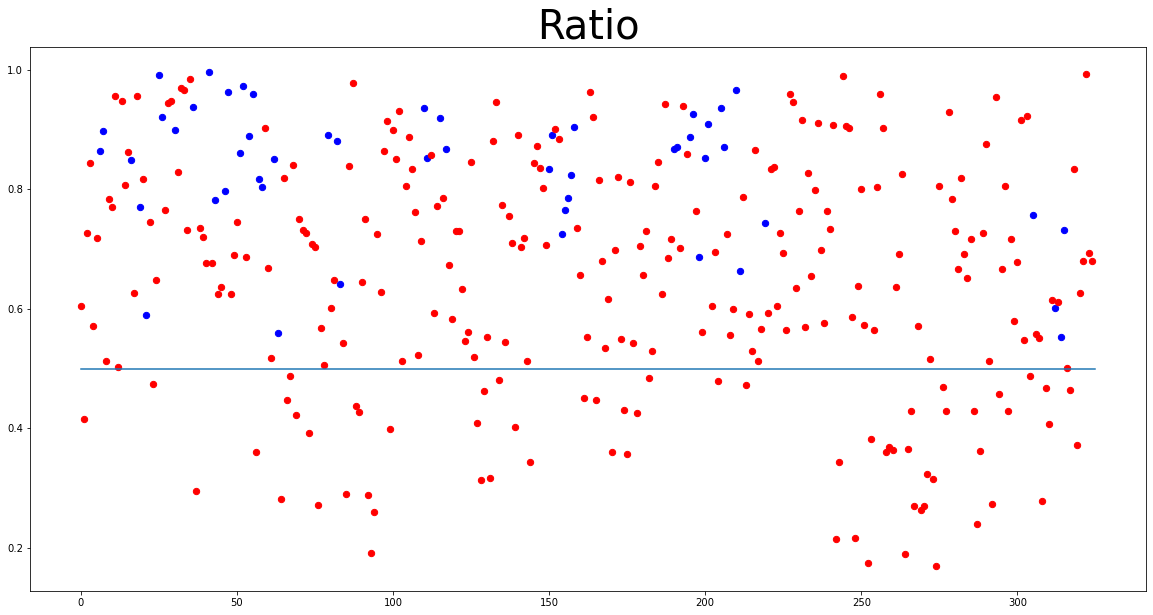

In [7]:
plt.figure(figsize=((20,10)))
for i,loop in enumerate(loop_list):
    if loop.context_diff is not None:
        if loop_grades[i]:
            plt.scatter(i,min(loop.ratio),s=40,c="blue")
        else:
            plt.scatter(i,min(loop.ratio),s=40,c="red")
plt.title("Ratio",fontsize=40)
plt.plot([0,len(loop_list)],[1/ratio_points,1/ratio_points])

## Overlap Test

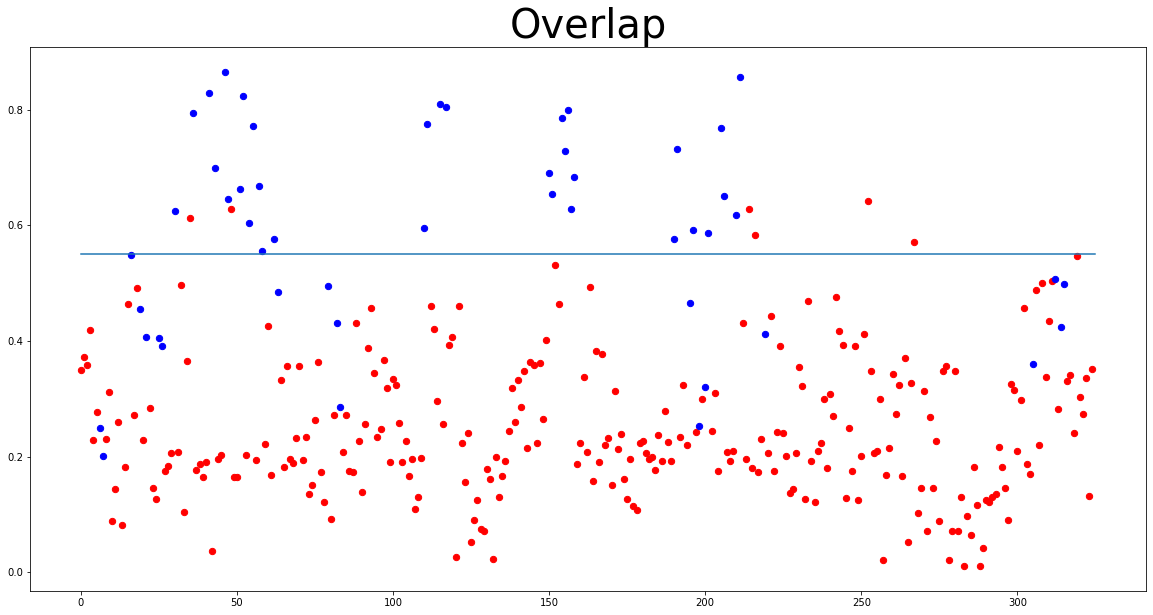

In [8]:
plt.figure(figsize=((20,10)))
for i,loop in enumerate(loop_list):
    if loop.context_diff is not None:
        if loop_grades[i]:
            plt.scatter(i,loop.overlap,s=40,c="blue")
        else:
            plt.scatter(i,loop.overlap,s=40,c="red")
plt.title("Overlap",fontsize=40)
plt.plot([0,len(loop_list)],[min_overlap,min_overlap])

## Scan context

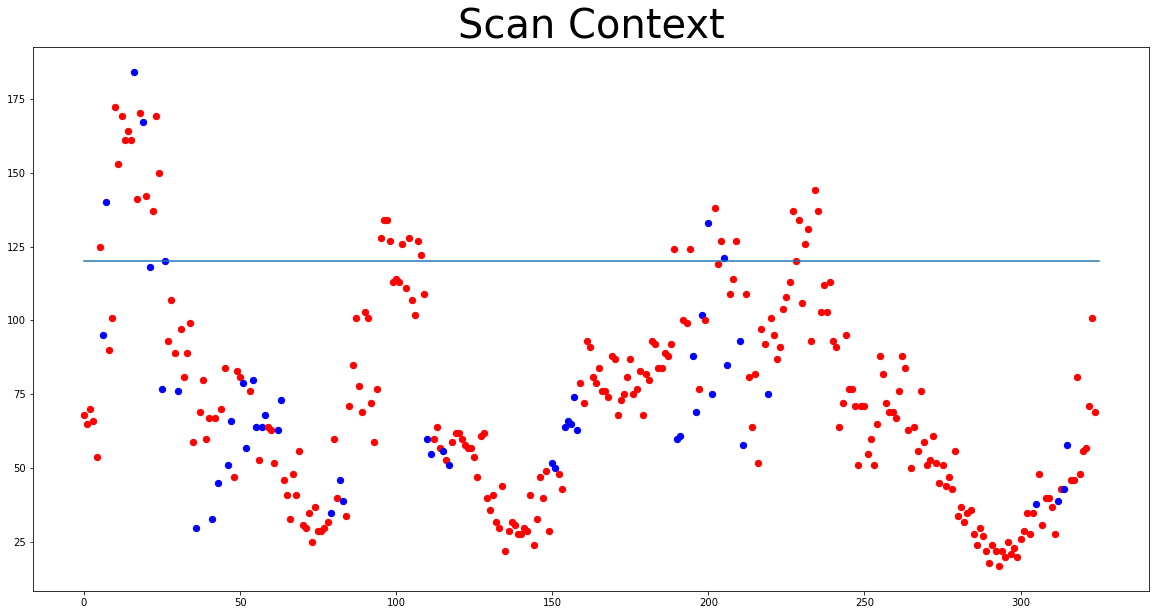

In [9]:
plt.figure(figsize=((20,10)))
for i,loop in enumerate(loop_list):
    if loop.context_diff is not None:
        if loop_grades[i]:
            plt.scatter(i,loop.context_diff,s=40,c="blue")
        else:
            plt.scatter(i,loop.context_diff,s=40,c="red")
plt.title("Scan Context",fontsize=40)
plt.plot([0,len(loop_list)],[context_difference,context_difference])